In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  RidgeCV
import shap
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt


### Some helper functions

In [ ]:
def get_score(model, feature, target):
    pred = model.predict(feature)
    score = pd.DataFrame(pred, columns=['Prediction'], index=feature.index)
    score['GroundTruth'] = np.array(target)
    score['AbsoluteError'] = abs(score['GroundTruth'] - score['Prediction'])
    return score

def get_doubtful_values(score, error=1.5):
    return score[score['AbsoluteError'] > error]

def get_truthful_values(score, error=0.5):
    return score[score['AbsoluteError'] < error]

### Load cleaned data

In [ ]:
data = pd.read_csv("data/data_cleaned.csv")
data = data.drop(["Unnamed: 0"], axis=1)

In [ ]:
data


### Train a model

In [ ]:
y = data["OverallQual"]
X = data.drop(["OverallQual", 'SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )

ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))

### Loc doubtful and truthful values

In [ ]:
y_pred = ridge.predict(X)
y_score = get_score(ridge, X, y)

y_correct = get_truthful_values(y_score, error=1)
y_doubt = get_doubtful_values(y_score, error=1)


### Get explanation for original model

In [ ]:
'''
Experiment:
- Original dataset, get doubtful value
- Corrupt this attrubute (the non-doubtful)
- See if the model discover the pattern.
'''
explainer = shap.Explainer(ridge, X, algorithm="linear", seed=100)
shap_values = explainer(X)

In [ ]:
"""
Get data that only include the correct prediction.
Two indexes need to be kept.
"""
data_correct = data.iloc[y_correct.index]
data_correct['data_index'] = data_correct.index
data_correct = data_correct.reset_index(drop=True)
data_correct['index'] = data_correct.index
data_correct.set_index(['index', 'data_index'], inplace=True)

### Corrupt OverallQual on data_correct dataframe.

In [ ]:
corruption_list = []
old_new_value = OrderedDict()
OverallQual_sample_fraction = 0.05

data_to_corrupt = data_correct.copy()

corruption_index_list = sorted(data_to_corrupt.sample(frac = OverallQual_sample_fraction, random_state=1).index)
for i in corruption_index_list:
    old = data_to_corrupt.loc[i, 'OverallQual']
    new = old - 6 if old > 6 else old + 6
    if new > 10: new = 10
    # while abs(old - new) != 6:
    #     new = np.random.randint(1, 11, 1)[0]
    data_to_corrupt.loc[i, 'OverallQual'] = new
    corruption_list.append(i)
    old_new_value[i[0]] = (old, new)
print(len(corruption_list))

y_corrupted = data_to_corrupt["OverallQual"]
X_corrupted = data_to_corrupt.drop(["OverallQual", 'SalePrice'], axis=1)


X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_corrupted, y_corrupted, test_size=0.1,random_state=100)
ridge_corrupt = RidgeCV()
ridge_corrupt.fit(X_train_cor, y_train_cor)
print(ridge_corrupt.score(X_test_cor, y_test_cor))

In [ ]:
y_corrupted_score = get_score(ridge_corrupt, X_corrupted, y_corrupted)
y_corrupted_doubt = get_doubtful_values(y_corrupted_score)
y_corrupted_doubt = y_corrupted_doubt.rename(columns={'GroundTruth' : 'CorruptedTruth', 'AbsoluteError': 'CorruptedError'})
y_corrupted_doubt['GroundTruth'] = y_corrupted_doubt.index.get_level_values(1).map(y[y_corrupted_doubt.index.get_level_values(1)])
y_corrupted_doubt['Corrupted'] = y_corrupted_doubt['GroundTruth'] != y_corrupted_doubt['CorruptedTruth']
y_corrupted_doubt['OrgPredict'] = y_corrupted_doubt.index.get_level_values(1).map(y_score.loc[y_corrupted_doubt.index.get_level_values(1)]['Prediction'])
y_corrupted_doubt = y_corrupted_doubt[['Prediction', 'OrgPredict', 'CorruptedTruth', 'GroundTruth', 'Corrupted', 'CorruptedError']]
y_corrupted_doubt[y_corrupted_doubt['Corrupted'] == True]

In [ ]:
y_corrupted_doubt[y_corrupted_doubt['Corrupted'] == False]

In [ ]:
shap.initjs()
explainer_corruption = shap.Explainer(ridge_corrupt, X_corrupted, algorithm="linear", seed=100)
shap_values_corruption = explainer_corruption(X_corrupted)

In [ ]:
def split_explanation_to_cohort_overallQual(shap_values_to_explain, data_to_explain):
    overallQual_explanation = {}

    for i in range(len(shap_values_to_explain)):
        overallQual = int(data_to_explain.iloc[i]['OverallQual'])
        if overallQual not in overallQual_explanation:
            overallQual_explanation[overallQual] = shap.Explanation(values=shap_values_to_explain.values[i],
                                                                    base_values=shap_values_to_explain.base_values[i],
                                                                    data=shap_values_to_explain.data[i],
                                                                    feature_names=shap_values_to_explain.feature_names)
        else:
            overallQual_explanation[overallQual].base_values = np.append(overallQual_explanation[overallQual].base_values,
                                                                         shap_values_to_explain.base_values[i])
            overallQual_explanation[overallQual].values = np.vstack([overallQual_explanation[overallQual].values,
                                                                     shap_values_to_explain.values[i]])
            overallQual_explanation[overallQual].data = np.vstack([overallQual_explanation[overallQual].data,
                                                                   shap_values_to_explain.data[i]])
    return overallQual_explanation

overallQual_explanation_original = split_explanation_to_cohort_overallQual(shap_values, data)
overallQual_explanation_corrupted = split_explanation_to_cohort_overallQual(shap_values_corruption, data_to_corrupt)


In [ ]:
print(y[corruption_list[0][1]])
shap.plots.waterfall(shap_values[corruption_list[0][1]], max_display=10)

In [ ]:
print(y_corrupted[corruption_list[0][0]])
shap.plots.waterfall(shap_values_corruption[corruption_list[0][0]], max_display=10)

### Plot differences in explanation between corrupted and original data.


In [ ]:
# values= (shap_values_corruption[corruption_list[0][0]].values - shap_values[corruption_list[0][1]].values).round(3)
# df_corrupt = pd.DataFrame([values], columns=shap_values_corruption.feature_names).sort_values(by=0, axis=1, ascending=True)
# df_corrupt = df_corrupt.loc[:,~(abs(df_corrupt.iloc[0]) < 0.05)]
#
# plt.figure(figsize=(8, 10))
# plt.barh(df_corrupt.columns, df_corrupt.iloc[0])
# plt.bar_label(plt.barh(df_corrupt.columns, df_corrupt.iloc[0]))
# plt.xlim(min(values) - 0.2, max(values) + 0.2)
# plt.show()

### Plot differences in explanation between corrupted and original data.

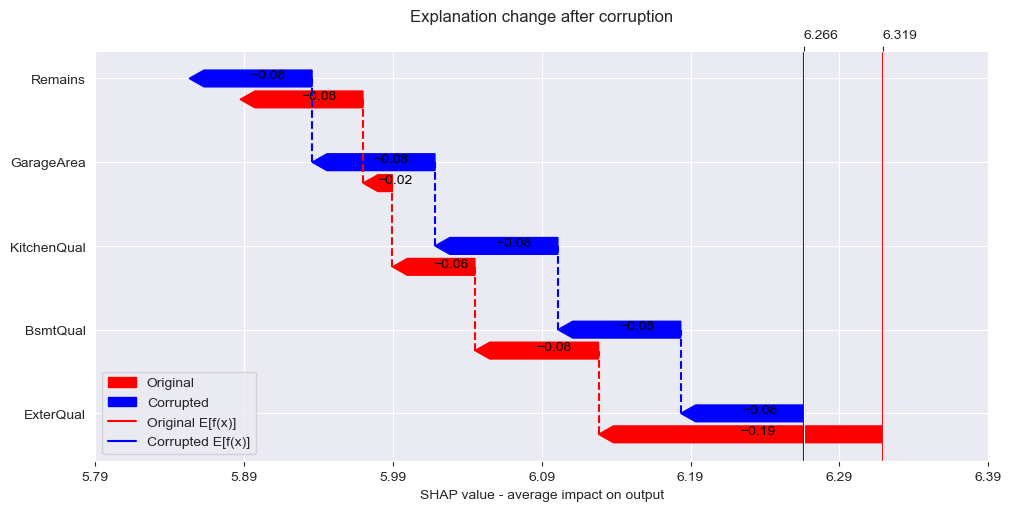

In [261]:
import re

def format_value(s, format_str):
    """ Strips trailing zeros and uses a unicode minus sign.
    """

    if not issubclass(type(s), str):
        s = format_str % s
    s = re.sub(r'\.?0+$', '', s)
    if s[0] == "-":
        s = u"\u2212" + s[1:]
    return s


def arrow_plot_comparing_explanations_values(original_explanation: shap.Explanation, corrupted_explanation: shap.Explanation, threshold=0.1):
    # Get Shapley values
    value_original = original_explanation.values
    value_corrupted = corrupted_explanation.values

    assert len(value_corrupted) == len(value_original), "Explanations must be of same length"

    # Get base values
    base_value_original = original_explanation.base_values
    base_value_corrupted = corrupted_explanation.base_values

    # Keep the list of features that are removed. Sum all those into one.
    remains_original = 0
    remains_corrupted = 0
    remove_list = []

    # Remove features that are below threshold and sum those together.
    for index in range(len(value_original)):
        if abs(value_corrupted[index]) < threshold and abs(value_original[index]) < threshold:
            remove_list.append(index)
            remains_corrupted += value_corrupted[index]
            remains_original += value_original[index]

    value_original = np.delete(value_original, remove_list)
    value_original = np.append(value_original, remains_original)

    value_corrupted = np.delete(value_corrupted, remove_list)
    value_corrupted = np.append(value_corrupted, remains_corrupted)

    col_list = np.delete(X.columns.to_numpy(), remove_list)
    col_list = np.append(col_list, 'Remains')

    # Plot
    fig, ax = plt.subplots(layout='constrained',figsize=(10, len(col_list)) )
    width = 0.25  # the width of the bars
    multiplier = 0
    dict_avg = {
        'Original': value_original,
        'Corrupted': value_corrupted
    }
    label_locations = np.arange(len(col_list))  # the label locations
    for attribute, measurement in dict_avg.items():
        offset = width * multiplier
        # rects = ax.barh(label_locations + offset, np.round(measurement, 3), width, label=attribute )

        if attribute == 'Original':
            base = base_value_original
            for i in range(len(measurement)):
                contribution = measurement[i]

                if i == 0:
                    label = attribute
                else:
                    label = None

                arrow = ax.arrow(base,
                         label_locations[i] + offset,
                         contribution,
                         0,
                         length_includes_head=True,
                         head_width=0.2,
                         head_length=0.01,
                         width=0.2,
                         color='red',
                         label=label,
                         )
                # ax.bar_label(arrow, padding=10)

                ax.text(
                    (base + base + contribution) / 2,
                    label_locations[i] + offset,
                    format_value(contribution, '%+0.02f'),
                    color="black",
                    fontsize=10,
                    )
                base += contribution

                if  i < len(measurement) - 1:
                    ax.plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'r', linestyle = '--',)


        else:
            base = base_value_corrupted
            for i in range(len(measurement)):
                if i == 0: label = attribute
                else: label = None
                ax.arrow(base,
                         label_locations[i] + offset,
                         contribution,
                         0,
                         length_includes_head=True,
                         head_width=0.2,
                         head_length=0.01,
                         width=0.2,
                         color='blue',
                         label=label,
                         )
                ax.text((base + base + contribution) / 2,
                        label_locations[i] + offset,
                        format_value(contribution, '%+0.02f'),
                        color="black",
                        fontsize=10,
                        )

                base += contribution
                if  i < len(measurement) - 1:
                    ax.plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'b', linestyle = '--',)

        # ax.bar_label(rects, padding=10)
        multiplier += 1
    ax.axvline(x = base_value_original, color = 'r', linestyle = '-', label='Original E[f(x)]')
    ax.axvline(x = base_value_corrupted, color = 'b', linestyle = '-', label='Corrupted E[f(x)]')

    ax.set_title('Explanation change after corruption')
    ax.set_yticks(label_locations + width, col_list)

    max_tick = np.round(max(base_value_original, base_value_corrupted, np.sum(value_original) + base_value_original, np.sum(value_corrupted) + base_value_corrupted) + 0.1, 2)
    min_tick = np.round(min(base_value_original, base_value_corrupted, np.sum(value_original) + base_value_original, np.sum(value_corrupted) + base_value_corrupted) - 0.1, 2)
    ax.set_xticks(np.arange(min_tick, max_tick, 0.1))


    # ax.set_xlim([-0.8 , 0.8 ])
    ax.set_xlabel('SHAP value - average impact on output')
    xmin, xmax = ax.get_xlim()

    ax2 = ax.twiny()
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks([ base_value_corrupted])
    ax2.set_xticklabels([ format_value(base_value_corrupted, "%0.03f")], ha="left")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)


    ax3 = ax.twiny()
    ax3.set_xlim(xmin, xmax)
    ax3.set_xticks([ base_value_original])
    ax3.set_xticklabels([format_value(base_value_original, "%0.03f")], ha="left")
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    ax.legend(loc='best')




# plot_comparing_explanations_values(shap_values.abs.mean(0).values, shap_values_corruption.abs.mean(0).values)
overall_qual = 6
arrow_plot_comparing_explanations_values(original_explanation=overallQual_explanation_original[overall_qual].mean(0), corrupted_explanation=overallQual_explanation_corrupted[overall_qual].mean(0), threshold=0.05)

In [ ]:
plot_comparing_explanations_values(overallQual_explanation_original[9].mean(0),  overallQual_explanation_corrupted[9].mean(0))

In [ ]:
plt.figure(figsize=(10, 15))
shap.summary_plot(shap_values,
                  plot_type='bar',
                  plot_size=None,
                  show=False,
                  sort=False,
                  max_display=100)

# plt.subplot(1,2,1)
# shap.summary_plot(shap_values,
#                   plot_type='bar',
#                   plot_size=None,
#                   show=False,
#                   sort=False,
#                   max_display=100)
# plt.xlim(0, 1)
# plt.title('Original')
# plt.subplot(1,2,2)
# shap.summary_plot(shap_values_corruption,
#                   plot_type='bar',
#                   plot_size=None,
#                   show=False,
#                   sort=False,
#                   max_display=100)
# plt.xlim(0, 0.5)
# plt.title('Corrupted')
# plt.tight_layout()
# plt.show()


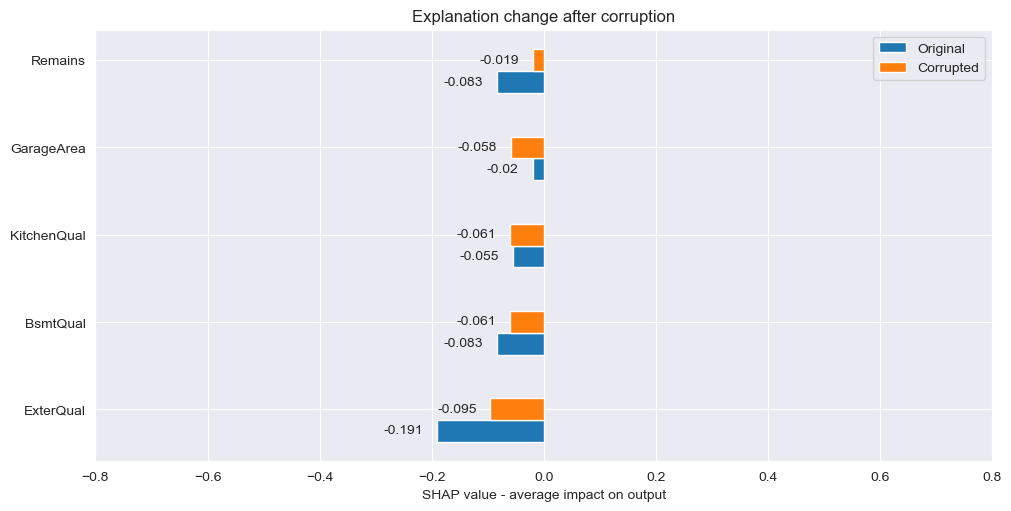

In [262]:
def bar_plot_comparing_explanations_values(original_explanation: shap.Explanation, corrupted_explanation: shap.Explanation, threshold=0.1):
    # Get Shapley values
    value_original = original_explanation.values
    value_corrupted = corrupted_explanation.values

    assert len(value_corrupted) == len(value_original), "Explanations must be of same length"

    # Get base value
    # Keep the list of features that are removed. Sum all those into one.
    remains_original = 0
    remains_corrupted = 0
    remove_list = []

    # Remove features that are below threshold and sum those together.
    for index in range(len(value_original)):
        if abs(value_corrupted[index]) < threshold and abs(value_original[index]) < threshold:
            remove_list.append(index)
            remains_corrupted += value_corrupted[index]
            remains_original += value_original[index]

    value_original = np.delete(value_original, remove_list)
    value_original = np.append(value_original, remains_original)

    value_corrupted = np.delete(value_corrupted, remove_list)
    value_corrupted = np.append(value_corrupted, remains_corrupted)

    col_list = np.delete(X.columns.to_numpy(), remove_list)
    col_list = np.append(col_list, 'Remains')

    # Plot
    fig, ax = plt.subplots(layout='constrained',figsize=(10, len(col_list)) )
    width = 0.25  # the width of the bars
    multiplier = 0
    dict_avg = {
        'Original': value_original,
        'Corrupted': value_corrupted
    }
    label_locations = np.arange(len(col_list))  # the label locations
    for attribute, measurement in dict_avg.items():
        offset = width * multiplier
        rects = ax.barh(label_locations + offset, np.round(measurement, 3), width, label=attribute )
        ax.bar_label(rects, padding=10)
        multiplier += 1
    ax.set_title('Explanation change after corruption')
    ax.set_yticks(label_locations + width, col_list)
    ax.set_xlim([-0.8 , 0.8 ])
    ax.set_xlabel('SHAP value - average impact on output')
    ax.legend(loc='best')


bar_plot_comparing_explanations_values(original_explanation=overallQual_explanation_original[overall_qual].mean(0), corrupted_explanation=overallQual_explanation_corrupted[overall_qual].mean(0), threshold=0.05)


In [ ]:
"""
Make explanation locally for each OverallQual:
i.e., how features contribute to each OverallQual values

- How many times it predict correct value instead of corruption value?
- Better
- Merging two figures (x)

Design experiment:

rough value on from what point the value degrades.
increase corruption percentage

"""

In [ ]:
df = pd.DataFrame([ridge.coef_], columns=ridge.feature_names_in_).sort_values(by=0, axis=1, ascending=True)
df_corrupt = pd.DataFrame([ridge_corrupt.coef_], columns=ridge_corrupt.feature_names_in_).sort_values(by=0, axis=1, ascending=True)
df_diff = (df_corrupt - df).sort_values(by=0, axis=1, ascending=True)
df_diff = df_diff.loc[:,~(abs(df_diff.iloc[0]) < 0.1)]
plt.figure(figsize=(5, 20))
plt.barh(df_diff.columns, df_diff.iloc[0])

In [ ]:
plt.plot([5, 5], [1, 5])